In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
import ast

# 0) 설정

BASE_PATH = "/Users/10moo/260128_proj"
START_DATE = "2023-05-13"
END_DATE   = "2024-05-07"

clean = Path(BASE_PATH) / "clean_vote_ver2"
dump  = Path(BASE_PATH) / "dump_vote_ver2"

start = pd.to_datetime(START_DATE)
end_excl = pd.to_datetime(END_DATE) + pd.Timedelta(days=1)

In [61]:
# 1) 로드

def read_csv(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"파일 없음: {path}")
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="utf-8-sig")
    except Exception:
        return pd.read_csv(path, encoding="cp949", errors="ignore")

accounts_user = read_csv(clean / "processed_accounts_user.csv")
accounts_school = read_csv(clean / "processed_accounts_school.csv")
accounts_group = read_csv(dump / "accounts_group.csv")
accounts_userquestionrecord = read_csv(clean / "processed_userquestionrecord.csv")
accounts_paymenthistory = read_csv(clean / "processed_accounts_paymenthistory.csv")
accounts_attendance = read_csv(dump / "accounts_attendance.csv")

In [62]:
# 2) pk & fk

USER_GROUP_FK = "group_id"
GROUP_PK = "id"
GROUP_SCHOOL_FK = "school_id"
SCHOOL_PK = "id" if "id" in accounts_school.columns and "school_id" not in accounts_school.columns else "school_id"

print("user_group FK:", USER_GROUP_FK)
print("group PK:", GROUP_PK)
print("group_school FK:", GROUP_SCHOOL_FK)
print("school PK:", SCHOOL_PK)

user_group FK: group_id
group PK: id
group_school FK: school_id
school PK: id


In [63]:
# 3) 기간 필터

def to_dt(df, col, name):
    df = df.copy()
    df[col] = pd.to_datetime(df[col], errors="coerce")
    nat = df[col].isna().sum()
    print(f"{name} > {col} NaT: {nat:,}, user_cnt: {len(df):,}")
    return df

accounts_user = to_dt(accounts_user, "created_at", "accounts_user")
accounts_userquestionrecord = to_dt(accounts_userquestionrecord, "created_at", "accounts_userquestionrecord")
accounts_paymenthistory = to_dt(accounts_paymenthistory, "created_at", "accounts_paymenthistory")

funnel_user = accounts_user[(accounts_user["created_at"] >= start) & (accounts_user["created_at"] < end_excl)].copy()
funnel_question = accounts_userquestionrecord[(accounts_userquestionrecord["created_at"] >= start) & (accounts_userquestionrecord["created_at"] < end_excl)].copy()
funnel_payment = accounts_paymenthistory[(accounts_paymenthistory["created_at"] >= start) & (accounts_paymenthistory["created_at"] < end_excl)].copy()

print("funnel_user:", len(funnel_user))
print("funnel_question:", len(funnel_question))
print("funnel_payment:", len(funnel_payment))

accounts_user > created_at NaT: 0, user_cnt: 676,978
accounts_userquestionrecord > created_at NaT: 0, user_cnt: 1,217,558
accounts_paymenthistory > created_at NaT: 0, user_cnt: 95,140
funnel_user: 363138
funnel_question: 809935
funnel_payment: 95137


In [64]:
# 4) 노출(팀원): 활성학교 student_count 합

active_school = accounts_school[accounts_school["is_active_school"] == True].copy()
exposure = int(active_school["student_count"].fillna(0).sum())

print("exposure:", exposure)

exposure: 655303


In [ ]:
# 5) 유입: 기간 내 가입 + 활성학교 재학생만
# join: user.group_id -> group.id -> group.school_id -> school.(id or school_id)

for df, col in [
    (funnel_user, "user_id"),
    (funnel_user, "group_id"),
    (accounts_group, "id"),
    (accounts_group, "school_id"),
    (accounts_school, SCHOOL_PK),
]:
    df[col] = df[col].astype("string")

abcde_user = pd.merge(
    funnel_user,
    accounts_group[["id", "school_id"]],
    left_on="group_id",
    right_on="id",
    how="left"
)
abcde_user = pd.merge(
    abcde_user,
    accounts_school[[SCHOOL_PK, "is_active_school"]],
    left_on="school_id",
    right_on=SCHOOL_PK,
    how="left"
)

# 활성학교
abcde_user = abcde_user[abcde_user["is_active_school"] == True].copy()

# 반 내 가입자 수 >= 4
group_size = abcde_user.groupby("group_id")["user_id"].nunique().reset_index(name="n_signup_in_group")
abcde_user = abcde_user.merge(group_size, on="group_id", how="left")
abcde_user = abcde_user[abcde_user["n_signup_in_group"] >= 4].copy()

inflow_users = abcde_user["user_id"].dropna().drop_duplicates()

print("inflow users:", inflow_users.nunique())


inflow users: 301886


In [66]:
# 6) 참여: questionrecord 능동+수동 union

funnel_question["user_id"] = funnel_question["user_id"].astype("string")
funnel_question["chosen_user_id"] = funnel_question["chosen_user_id"].astype("string")

abcde_question = funnel_question[funnel_question["user_id"].isin(set(inflow_users.tolist()))].copy()

active_u = abcde_question["user_id"].dropna().drop_duplicates()
passive_u = abcde_question["chosen_user_id"].dropna().drop_duplicates()
participation_u = pd.concat([active_u, passive_u], ignore_index=True).drop_duplicates()

print("active:", active_u.nunique())
print("passive:", passive_u.nunique())
print("total:", participation_u.nunique())

active: 1705
passive: 6076
total: 6095


In [67]:
# 7) 리텐션: 최초 참여일 다음날부터 출석 있으면 True

def normalize_att(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    s = str(x).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else []
        except Exception:
            return []
    return [s]

att = accounts_attendance.copy()
att["user_id"] = att["user_id"].astype("string")
att["attendance_date_list"] = att["attendance_date_list"].apply(normalize_att)
att = att.explode("attendance_date_list").dropna(subset=["attendance_date_list"])
att["attendance_date_list"] = pd.to_datetime(att["attendance_date_list"], errors="coerce")
att = att.dropna(subset=["attendance_date_list"])

# 출석도 같은 기간으로 필터
att = att[(att["attendance_date_list"] >= start) & (att["attendance_date_list"] < end_excl)].copy()

# 참여 "최초 시점" 계산(능동/수동 통합)
q = abcde_question[["user_id", "chosen_user_id", "created_at"]].copy()
q["created_at"] = pd.to_datetime(q["created_at"], errors="coerce")

first_choose = q[["user_id", "created_at"]].dropna()
first_chosen = q[["chosen_user_id", "created_at"]].dropna().rename(columns={"chosen_user_id": "user_id"})
first_question = pd.concat([first_choose, first_chosen], ignore_index=True).dropna()
first_question = first_question.sort_values("created_at").drop_duplicates(subset="user_id", keep="first")

att_part = att[att["user_id"].isin(set(participation_u.tolist()))].copy()
att_merge = pd.merge(att_part, first_question, on="user_id", how="left")

att_merge["first_day_plus1"] = att_merge["created_at"].dt.normalize() + pd.Timedelta(days=1)
att_merge["is_retention"] = att_merge["attendance_date_list"] >= att_merge["first_day_plus1"]

retention_users = att_merge.loc[att_merge["is_retention"] == True, "user_id"].dropna().drop_duplicates()

print("retention users:", retention_users.nunique())

retention users: 3177


In [68]:
# 8) 수익

funnel_payment["user_id"] = funnel_payment["user_id"].astype("string")

rev_ret = funnel_payment[funnel_payment["user_id"].isin(set(retention_users.tolist()))]["user_id"].dropna().drop_duplicates()
rev_be  = funnel_payment[funnel_payment["user_id"].isin(set(inflow_users.tolist()))]["user_id"].dropna().drop_duplicates()

print("revenue (retention base):", rev_ret.nunique())
print("revenue (inflow base b-e):", rev_be.nunique())

revenue (retention base): 472
revenue (inflow base b-e): 34369


In [69]:
accounts_school["is_active_school"].value_counts(dropna=False)

is_active_school
True     3897
False    2054
Name: count, dtype: int64

In [70]:
abcde_user["is_active_school"].isna().sum()

np.int64(0)

In [71]:
# 유입 후보(활성학교+기간가입) 상태에서 확인
tmp = abcde_user.copy()

print("group_id NaN:", tmp["group_id"].isna().sum())
print("group_id 공백:", (tmp["group_id"].astype(str).str.strip() == "").sum())

# group_id가 이상한 유저 20명만 보기
bad = tmp[tmp["group_id"].isna() | (tmp["group_id"].astype(str).str.strip() == "")]
bad[["user_id","group_id"]].head(20)


group_id NaN: 0
group_id 공백: 0


,user_id,group_id


In [72]:
dup = funnel_user.groupby("user_id").size().reset_index(name="cnt")
dup = dup[dup["cnt"] > 1].sort_values("cnt", ascending=False)
print("중복 user_id 수:", len(dup))
dup.head(20)


중복 user_id 수: 0


,user_id,cnt


In [73]:
# abcde_user에 n_signup_in_group 붙어있는 상태라고 가정
edge = abcde_user[abcde_user["n_signup_in_group"].isin([3,4,5])].copy()

print(edge["n_signup_in_group"].value_counts())

# 특히 4인 반 유저 목록
edge4 = edge[edge["n_signup_in_group"] == 4][["user_id","group_id"]].drop_duplicates()
edge4.head(30), len(edge4)


n_signup_in_group
5    17540
4    17196
Name: count, dtype: int64


(     user_id group_id
 23   1051061    16812
 35   1184904    42654
 36   1184905    47093
 43   1184913    51504
 47   1184918    51132
 53   1184924    29388
 56   1184927    44968
 76   1184949    51510
 79   1184952    17103
 87   1184961     7652
 109  1184983    13431
 118  1184993    24277
 144  1185026     2684
 156  1185040    51516
 166  1185051    45751
 180  1185065    13999
 184  1185070    41791
 220  1185114     9381
 230  1185124    43848
 239  1185135      962
 243  1185139    27955
 266  1185162    17786
 268  1185164    17309
 287  1185186    45987
 302  1185201    23045
 312  1185214    35318
 330  1185237    45987
 340  1185249    16220
 356  1185267    22821
 372  1185284    39529,
 17196)

In [74]:
# 4명 반 목록
g4 = abcde_user.loc[abcde_user["n_signup_in_group"] == 4, "group_id"].drop_duplicates()
print("4명 반 개수:", g4.nunique())

# 4명 반에 속한 유저 수(너가 본 17196과 같아야 정상)
u4 = abcde_user[abcde_user["group_id"].isin(set(g4.tolist()))]["user_id"].nunique()
print("4명 반 유저 수:", u4)

4명 반 개수: 4299
4명 반 유저 수: 17196


In [75]:
# 유입 유저의 가입 시각
signup_time = abcde_user.drop_duplicates("user_id")[["user_id","created_at"]].copy()
signup_time = signup_time.rename(columns={"created_at":"signup_at"})

# 참여 유저의 첫 투표 시각(능동/수동 둘 다)
q = abcde_question[["user_id","chosen_user_id","created_at"]].copy()
q["created_at"] = pd.to_datetime(q["created_at"], errors="coerce")

first_choose = q[["user_id","created_at"]].dropna().rename(columns={"created_at":"first_participate_at"})
first_chosen = q[["chosen_user_id","created_at"]].dropna().rename(columns={"chosen_user_id":"user_id","created_at":"first_participate_at"})
first_part = pd.concat([first_choose, first_chosen], ignore_index=True)
first_part = first_part.sort_values("first_participate_at").drop_duplicates("user_id", keep="first")

tmp = signup_time.merge(first_part, on="user_id", how="left")
tmp["days_to_participate"] = (tmp["first_participate_at"] - tmp["signup_at"]).dt.days

# 분포 확인
print(tmp["days_to_participate"].value_counts(dropna=False).sort_index().head(20))
print("가입 후 0일 내 참여율:", (tmp["days_to_participate"]==0).mean())
print("가입 후 7일 내 참여율:", (tmp["days_to_participate"]<=7).mean())


days_to_participate
0.0     2362
1.0      345
2.0      198
3.0      152
4.0      122
5.0       88
6.0       70
7.0       54
8.0       60
9.0       40
10.0      34
11.0      44
12.0      28
13.0      33
14.0      21
15.0      16
16.0       5
17.0       4
18.0       8
19.0       4
Name: count, dtype: int64
가입 후 0일 내 참여율: 0.007824145538382038
가입 후 7일 내 참여율: 0.011232716985882088


In [76]:
active_set = set(abcde_question["user_id"].dropna().astype(str).unique())
passive_set = set(abcde_question["chosen_user_id"].dropna().astype(str).unique())

both = active_set & passive_set
only_active = active_set - passive_set
only_passive = passive_set - active_set

print("능동만:", len(only_active))
print("수동만:", len(only_passive))
print("둘다:", len(both))
print("전체 참여:", len(active_set | passive_set))


능동만: 19
수동만: 4390
둘다: 1686
전체 참여: 6095


In [77]:
# 유입 유저 기준으로 세그먼트 테이블 만들기
base = abcde_user.drop_duplicates("user_id")[["user_id","group_id"]].copy()
base["is_participated"] = base["user_id"].isin(set(participation_u.astype(str).tolist())).astype(int)

seg = base.groupby("group_id").agg(
    inflow=("user_id","nunique"),
    participated=("is_participated","sum")
).reset_index()
seg["p_rate"] = seg["participated"] / seg["inflow"]

# 유입이 큰데 참여율 낮은 반 TOP
seg = seg.sort_values(["inflow","p_rate"], ascending=[False, True])
seg.head(20)


,group_id,inflow,participated,p_rate
24666,67097,80,0,0.000000
16061,53560,66,0,0.000000
20381,59890,55,0,0.000000
7930,39451,52,0,0.000000
9038,41946,52,0,0.000000
8247,4021,51,0,0.000000
17898,56063,50,0,0.000000
14510,51408,48,5,0.104167
6453,35726,46,0,0.000000
27991,73024,44,0,0.000000


In [78]:
non_part = set(inflow_users.astype(str)) - set(participation_u.astype(str))
non_part = list(non_part)

# 비참여 유저 중 출석이라도 있는지(=앱 방문은 했는지)
att_u = set(accounts_attendance["user_id"].astype(str).unique())
print("비참여인데 출석은 있는 유저:", len(set(non_part) & att_u))


비참여인데 출석은 있는 유저: 183947


In [79]:
base = abcde_user.copy()

base["is_participated"] = base["user_id"].isin(
    set(participation_u.astype(str))
).astype(int)

summary = base.groupby("is_participated").agg(
    users=("user_id","nunique"),
    avg_group_size=("n_signup_in_group","mean"),
).reset_index()

summary


,is_participated,users,avg_group_size
0,0,298157,11.802624
1,1,3729,12.785465


In [80]:
group_effect = (
    base.groupby("n_signup_in_group")["is_participated"]
    .mean()
    .reset_index(name="participation_rate")
)

group_effect.sort_values("n_signup_in_group")


,n_signup_in_group,participation_rate
0,4,0.008316
1,5,0.009179
2,6,0.008269
3,7,0.010111
4,8,0.010800
5,9,0.011660
6,10,0.011231
7,11,0.012567
8,12,0.012562
9,13,0.010360


In [81]:
ready_users = base[
    (base["n_signup_in_group"] >= 4) &
    (base["is_participated"] == 0)
]

In [82]:
len(ready_users)

298157

In [83]:
# user_id 기준 투표 횟수
vote_cnt = (
    abcde_question
    .groupby("user_id")
    .size()
    .reset_index(name="vote_count")
)

# 2회 이상 투표 유저
repeat_voters = vote_cnt[vote_cnt["vote_count"] >= 2]["user_id"]

print("투표 2회 이상 유저 수:", repeat_voters.nunique())

투표 2회 이상 유저 수: 1697


In [84]:
repeat_voters_inflow = repeat_voters[
    repeat_voters.isin(set(inflow_users.astype(str)))
]

print("유입 → 투표 2회 이상:", repeat_voters_inflow.nunique())

유입 → 투표 2회 이상: 1697


In [85]:
active = (abcde_question[["user_id"]].rename(columns={"user_id":"user"}))

passive = (abcde_question[["chosen_user_id"]].rename(columns={"chosen_user_id":"user"}))

all_participation = pd.concat([active, passive], ignore_index=True)

participation_cnt = (all_participation.groupby("user").size().reset_index(name="participation_count")
)

repeat_participants = participation_cnt[
    participation_cnt["participation_count"] >= 2
]["user"]

print("참여 2회 이상 유저:", repeat_participants.nunique())


참여 2회 이상 유저: 5429


In [86]:
base = abcde_user[["user_id"]].drop_duplicates()

base["repeat_voter"] = base["user_id"].isin(set(repeat_voters)).astype(int)
base["payer"] = base["user_id"].isin(
    set(accounts_paymenthistory["user_id"].astype(str))
).astype(int)

pd.crosstab(base["repeat_voter"], base["payer"], normalize="index")

payer,0,1
repeat_voter,,
0,0.886222,0.113778
1,0.873895,0.126105


- 수익 관련 분석

In [87]:
accounts_paymenthistory.columns

Index(['user_id', 'productId', 'phone_type', 'created_at'], dtype='object')

In [88]:
candidates = {
    "accounts_paymenthistory": accounts_paymenthistory,
    "event_receipts": globals().get("event_receipts", None),
    "events": globals().get("events", None),
}

for name, df in candidates.items():
    if df is None:
        continue
    cols = [c.lower() for c in df.columns]
    money_cols = [c for c in df.columns if any(k in c.lower() for k in ["price","amount","value","revenue","cost","currency","money","paid"])]
    pid_cols = [c for c in df.columns if "product" in c.lower() or "sku" in c.lower() or "item" in c.lower()]
    print(f"\n[{name}] rows={len(df):,}")
    print("  money-ish:", money_cols)
    print("  product-ish:", pid_cols[:10])



[accounts_paymenthistory] rows=95,140
  money-ish: []
  product-ish: ['productId']

[event_receipts] rows=309
  money-ish: []
  product-ish: []

[events] rows=3
  money-ish: []
  product-ish: []


In [89]:
import pandas as pd
import os

base = "/Users/10moo/260128_proj"
dump = os.path.join(base, "dump_vote_ver2")

event_receipts = pd.read_csv(os.path.join(dump, "event_receipts.csv"))
events = pd.read_csv(os.path.join(dump, "events.csv"))

print(event_receipts.shape, events.shape)
print("event_receipts cols:", list(event_receipts.columns))
print("events cols:", list(events.columns))

(309, 5) (3, 6)
event_receipts cols: ['id', 'created_at', 'event_id', 'user_id', 'plus_point']
events cols: ['id', 'title', 'plus_point', 'event_type', 'is_expired', 'created_at']


- 정확한 금액을 알 수 있는 컬럼이나 테이블이 없었던 기억
- 지피티한테, 가격과 관련한 컬럼이 있는지 교차검증 할 수 있는 코드 짜달라고 해서 해클까지 확인
    - 구체적인 매출을 알 수 있는 방법은 없을듯 함

In [90]:
# 형변환, 날짜 설정

pay = accounts_paymenthistory.copy()

pay["user_id"] = pay["user_id"].astype(str)
pay["created_at"] = pd.to_datetime(pay["created_at"])

START = pd.to_datetime("2023-05-13")
END = pd.to_datetime("2024-05-07")

pay = pay[(pay["created_at"] >= START) & (pay["created_at"] <= END)]

In [91]:
inflow_set = set(inflow_users.astype(str))
part_set = set(participation_u.astype(str))

In [92]:
# 함수로 작성
def heart_kpis(base_set, label):

    # 전체 결제 중에서 유입/참여 유저가 한 결제만 가져옴
    sub = pay[pay["user_id"].isin(base_set)].copy()

    # 분석 유저 수
    users_cnt = len(base_set)
    # 실제로 하트를 한번이라도 산 사람
    buyers = sub["user_id"].nunique()
    # 결제 이벤트 수
    tx = len(sub)

    # 구매 횟수 유저별로 카운트
    user_tx = sub.groupby("user_id").size()

    # 평균 구매 횟수
    freq = tx / max(1, buyers)
    # 재구매 유저
    repurchase = (user_tx >= 2).sum()
    # 재구매율
    repurchase_rate = repurchase / max(1, buyers)

    print(f"{label} → 하트 수익")
    print("기준 유저:", users_cnt)
    print("하트 구매 유저:", buyers)
    print("구매 전환율:", buyers / max(1, users_cnt))
    print("총 구매 건수:", tx)
    print("구매자당 평균 구매:", freq)
    print("재구매 유저:", repurchase)
    print("재구매율:", repurchase_rate)

    print("\n상품 별 구매자 수")
    print(sub["productId"].value_counts().head(10))

In [93]:
heart_kpis(inflow_set, "유입")

유입 → 하트 수익
기준 유저: 301886
하트 구매 유저: 34369
구매 전환율: 0.1138476113499798
총 구매 건수: 57401
구매자당 평균 구매: 1.670138787861154
재구매 유저: 9971
재구매율: 0.29011609299077656

상품 별 구매자 수
productId
heart.777     33592
heart.1000    12354
heart.200     10128
heart.4000     1327
Name: count, dtype: int64


In [94]:
heart_kpis(part_set, "참여")

참여 → 하트 수익
기준 유저: 6095
하트 구매 유저: 673
구매 전환율: 0.11041837571780147
총 구매 건수: 1150
구매자당 평균 구매: 1.7087667161961366
재구매 유저: 193
재구매율: 0.2867756315007429

상품 별 구매자 수
productId
heart.777     663
heart.1000    261
heart.200     200
heart.4000     26
Name: count, dtype: int64


- 유입 퍼널의 결제 전환율: 11.3%, 재구매율: 29%
- 참여 퍼널의 결제 전환율: 11.0%, 재구매율: 28.6%
    - 구매는 참여의 깊이보다 서비스 진입 초반 상태에서 이미 결정됨
- 평균 구매 횟수: 약 1.7회
- 중간 가격 상품(777개)이 메인


In [95]:
# 일부 유저들만 구매를 하는건지

user_purchase = pay.groupby("user_id").size().reset_index(name="tx")

# 유저별 구매 횟수
# 10등급으로 나눔
# 각 그룹이 만든 총 구매량 합계
user_purchase["percentile"] = pd.qcut(user_purchase["tx"], q=10, labels=False, duplicates="drop")

user_purchase.groupby("percentile")["tx"].sum()

# 가장 구매를 적게 한 유저 그룹인데 전체 구매의 가장 많은 양을 차지

percentile
0    60212
1    10266
2    24658
Name: tx, dtype: int64

In [96]:
# 구매 속도

# 가입 시간
signup_time = accounts_user[["user_id","created_at"]].copy()
signup_time["created_at"] = pd.to_datetime(signup_time["created_at"])

# 구매 최초 시간
purchase_time = pay.groupby("user_id")["created_at"].min().reset_index()
purchase_time["created_at"] = pd.to_datetime(purchase_time["created_at"])

# 타입 통일
signup_time["user_id"] = signup_time["user_id"].astype(str)
purchase_time["user_id"] = purchase_time["user_id"].astype(str)

# merge
speed = signup_time.merge(purchase_time, on="user_id", how="inner", suffixes=("_signup", "_buy"))

# 구매까지 걸린 시간
# 가입일 ~ 첫 하트 구매까지 걸린 일수
speed["days_to_buy"] = (speed["created_at_buy"] - speed["created_at_signup"]).dt.days

speed["days_to_buy"].describe()

count    59177.000000
mean         9.206313
std         24.112832
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        372.000000
Name: days_to_buy, dtype: float64

- 하트 구매까지 이어진 유저 수: 59177명(가입 -> 하트 구매 기록)
- 평균 구매까지 9.2일이 걸림
- 표준편차가 평균보다 훨씬 큼
    - max 구매 유저가 372일이므로 표준편차 차이가 나는 듯
    - 구매 타이밍이 매우 제각각, 유저 팽동 패턴이 하나가 아님
- 구매 유저 절반이 가입 후 3일 안에 결제
- 🟢중앙값 3일로 대부분의 구매가 가입 초기 단계에서 발생, 일부 장기 지연 구매자가 존재해 분산은 크지만, 전체적으로 초기 경험 구간에서 수익 전환이 집중되는 구조를 보임

- 참여도 보자!!!

In [100]:
# 1) 질문/투표 로그 기간 필터 + 유입 유저만
q = funnel_question.copy()
q["created_at"] = pd.to_datetime(q["created_at"])
q = q[(q["created_at"] >= START) & (q["created_at"] <= END)].copy()

# 타입 통일(merge/isin 안정성)
q["user_id"] = q["user_id"].astype(str)
q["chosen_user_id"] = q["chosen_user_id"].astype(str)

q = q[q["user_id"].isin(inflow_set)].copy()

# 2) 참여 유저 정의 = 능동(user_id) + 수동(chosen_user_id)
active_users  = set(q["user_id"].unique())
passive_users = set(q["chosen_user_id"].unique())

part_users = active_users | passive_users

print("능동 유저:", len(active_users))
print("수동 유저:", len(passive_users))
print("참여(능동+수동) 유저:", len(part_users))

능동 유저: 1705
수동 유저: 6076
참여(능동+수동) 유저: 6095


In [101]:
# 3) 첫 참여 시간(능동/수동 모두 포함)
# 능동: user_id 기준
active_time = (
    q.groupby("user_id")["created_at"].min()
     .reset_index()
     .rename(columns={"user_id": "user", "created_at": "first_part_at"})
)

# 수동: chosen_user_id 기준
passive_time = (
    q.groupby("chosen_user_id")["created_at"].min()
     .reset_index()
     .rename(columns={"chosen_user_id": "user", "created_at": "first_part_at"})
)

# 둘을 합쳐서 "유저별 첫 참여시간"으로 최종 집계
part_time = (
    pd.concat([active_time, passive_time], ignore_index=True)
      .groupby("user")["first_part_at"].min()
      .reset_index()
)

# 4) 구매 기간 필터 + 타입 통일
pay = accounts_paymenthistory.copy()
pay["created_at"] = pd.to_datetime(pay["created_at"])
pay = pay[(pay["created_at"] >= START) & (pay["created_at"] <= END)].copy()
pay["user_id"] = pay["user_id"].astype(str)

# 유저별 첫 구매
buy_time = (
    pay.groupby("user_id")["created_at"].min()
       .reset_index()
       .rename(columns={"user_id": "user", "created_at": "first_buy_at"})
)

In [103]:
# 5) 참여 → 구매 속도
speed_part = part_time.merge(buy_time, on="user", how="inner")
speed_part["days_to_buy"] = (speed_part["first_buy_at"] - speed_part["first_part_at"]).dt.days

print("참여 > 구매 유저 수:", len(speed_part))
print("음수(구매가 참여보다 빠름) 개수:", (speed_part["days_to_buy"] < 0).sum())

speed_part["days_to_buy"].describe()

참여 > 구매 유저 수: 673
음수(구매가 참여보다 빠름) 개수: 226


count    673.000000
mean       0.696880
std       18.661863
min     -129.000000
25%       -2.000000
50%        0.000000
75%        1.000000
max      287.000000
Name: days_to_buy, dtype: float64

- 투표보다 하트 구매가 먼저 진행된 유저들: 226명
- 데이터가 잘렸을 수도 있고, 실제로 하트를 먼저 구매했을 수도 있음
    - 하위 25%는 이미 구매 상태였음
    - !!!!!!!절반의 유저가 참여 당일 하트 구매!!!!!!!
    - 70% 유저가 1일 이내 구매
- 참여 유저들은 평균 약 0.7일 안에 구매(분산은 큼)
- 🟢참여 이후 구매는 즉시 전환 패턴, 구매 유저 절반 이상이 참여 당일 하트 구매하는 강한 단기 전환 구조를 보임

In [110]:
# 매출이 일부 유저들에게 매몰되어있는가?

user_tx = pay.groupby("user_id").size().reset_index(name="tx")

# 유저를 구매 횟수 기준 그룹화
user_tx["group"] = pd.qcut(user_tx["tx"], q=5, labels=False, duplicates="drop")

user_tx.groupby("group")["tx"].agg(["count","sum"])
# 5그룹으로 나누려고 했는데, 자동으로 2그룹만 생성됨
# 0그룹: 51631명(약 87%), 1인당 약 1.16회 구매
# 1그룹: 7560명(약 13%), 1인당 약 4.6회
# 1그룹의 구매 비중(34924/95136): 약 36.7%
# 전체 구매의 약 37%가 상위 13% 유저한테서 발생
# 🟢 하트 매출은 일반 유저가 아니라 반복 구매 소수 유저에 의해 크게 유지되는 구조

,count,sum
group,,
0,51631,60212
1,7560,34924


In [ ]:
# 분포 확인
user_tx["tx"].describe()

# 하트를 한번이라도 구매한 유저 수: 59191
# 유저의 75%가 2회 이하로 구매
# 하트를 가장 많이 산 유저는 60번 구매함

count    59191.000000
mean         1.607271
std          1.560486
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         60.000000
Name: tx, dtype: float64

In [ ]:
# 재구매 유저 비율
(user_tx["tx"] >= 2).mean()
# 재구매 비율은 약 27.3%
# 73%는 1회 구매 후 이탈, 27%는 반복 구매 유저

np.float64(0.2726934838066598)

In [115]:
# 3번 이상 구매 한 유저

heavy_users = user_tx[user_tx["tx"] >= 3]["user_id"]

In [ ]:
# 3번 이상 = 헤비 유저

heavy_part = set(map(str, heavy_users)) & set(map(str, part_users))
print("헤비유저 참여유저 합집합:", len(heavy_part))

헤비유저 참여유저 합집합: 109


In [124]:
heavy_inflow = set(map(str, heavy_users)) & set(map(str, inflow_users))  # inflow_users는 너 유입 유저 변수명으로
print("헤비유저 유입유저 합집합:", len(heavy_inflow))

헤비유저 유입유저 합집합: 4811


In [ ]:
print("헤비 중 참여 비율:", len(heavy_part) / len(heavy_users))

print("헤비 중 유입 비율:", len(heavy_inflow) / len(heavy_users))

헤비 중 참여 비율: 0.014417989417989418
헤비 중 유입 비율: 0.6363756613756614


In [125]:
### 참여를 많이 할수록 구매를 많이 하는가???

# 유저별 참여 횟수
part_cnt = participation.groupby("user").size().reset_index(name="part_cnt")

# 구매 여부
buyer = set(pay["user_id"].astype(str).unique())

part_cnt["is_buyer"] = part_cnt["user"].astype(str).isin(buyer)

# 참여량 구간 나누기
part_cnt["group"] = pd.qcut(
    part_cnt["part_cnt"],
    q=4,
    labels=["low","mid-low","mid-high","high"],
    duplicates="drop"
)

# 그룹별 구매율
part_cnt.groupby("group")["is_buyer"].mean()

/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_2773/4123198832.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  part_cnt.groupby("group")["is_buyer"].mean()


group
low         0.101641
mid-low     0.108458
mid-high    0.095863
high        0.136005
Name: is_buyer, dtype: float64

In [126]:
# 참여한 사람이 더 많이 재구매 하는가?

re_user = set(user_tx[user_tx["tx"] >= 2]["user_id"].astype(str))

part_cnt["is_repeat"] = part_cnt["user"].astype(str).isin(re_user)

part_cnt.groupby("group")["is_repeat"].mean()

/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_2773/3716913374.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  part_cnt.groupby("group")["is_repeat"].mean()


group
low         0.033460
mid-low     0.032742
mid-high    0.022981
high        0.037451
Name: is_repeat, dtype: float64

In [128]:
pay["user_id"].nunique()

59191

In [129]:
# 구매자 집단을 정리
all_buyers = set(pay["user_id"].astype(str).unique())
inflow_buyers = all_buyers & set(map(str, inflow_users))
part_buyers = all_buyers & set(map(str, part_users))

In [130]:
# 각 그룹별 pay 데이터
pay["user_id"] = pay["user_id"].astype(str)

pay_all = pay.copy()

pay_inflow = pay[pay["user_id"].isin(inflow_buyers)].copy()

pay_part = pay[pay["user_id"].isin(part_buyers)].copy()

In [132]:
# 구매 횟수 분포
def purchase_stats(df):
    user_tx = df.groupby("user_id").size().reset_index(name="tx")
    return user_tx["tx"].describe()

purchase_stats(pay_all)

count    59191.000000
mean         1.607271
std          1.560486
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         60.000000
Name: tx, dtype: float64

In [133]:
purchase_stats(pay_inflow)

count    34369.000000
mean         1.670139
std          1.675935
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         60.000000
Name: tx, dtype: float64

In [134]:
purchase_stats(pay_part)

count    673.000000
mean       1.708767
std        1.681888
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       20.000000
Name: tx, dtype: float64

- 한번에 정리좀 하기

In [139]:
# 타입 통일
pay = pay.copy()
pay["user_id"] = pay["user_id"].astype(str)

# 구매자 set
buyers = set(pay["user_id"].unique())

# 3개 집단
group_sets = {
    "전체구매자": buyers,
    "유입→구매자": set(map(str, inflow_users)) & buyers,
    "참여→구매자": set(map(str, part_users)) & buyers,
}

In [137]:
def purchase_kpis_for_group(pay_df, buyer_set, base_set=None, label=""):
    
    buyer_set = set(map(str, buyer_set))
    sub = pay_df[pay_df["user_id"].isin(buyer_set)].copy()

    # 유저별 구매 횟수
    user_tx = sub.groupby("user_id").size().rename("tx")
    buyers_cnt = user_tx.shape[0]
    total_tx = int(user_tx.sum())

    # 4) 재구매율 (구매자 중 2회 이상)
    repeat_buyers = int((user_tx >= 2).sum())
    repurchase_rate = repeat_buyers / max(1, buyers_cnt)

    # 5) 매출 집중도(=구매건수 집중도)
    # Top x% 유저가 차지하는 구매건수 비중
    def top_share(p):
        if buyers_cnt == 0:
            return 0.0
        k = max(1, int(np.ceil(buyers_cnt * p)))
        top_tx = user_tx.sort_values(ascending=False).head(k).sum()
        return float(top_tx / max(1, total_tx))

    top1 = top_share(0.01)
    top5 = top_share(0.05)
    top10 = top_share(0.10)

    # 6) vs 구매율, 7) vs 재구매율 (기준 유저가 있을 때)
    if base_set is None:
        base_set = buyer_set
    base_set = set(map(str, base_set))
    base_cnt = len(base_set)

    # 구매율: (구매자 / 기준유저)
    buy_rate_vs_base = buyers_cnt / max(1, base_cnt)

    # 재구매율(vs 기준유저): (재구매자 / 기준유저)
    repeat_rate_vs_base = repeat_buyers / max(1, base_cnt)

    out = {
        "집단": label,
        "기준유저수": base_cnt,
        "구매자수": buyers_cnt,
        "구매율(vs기준)": buy_rate_vs_base,
        "구매건수(=매출대용)": total_tx,
        "구매자당평균구매": total_tx / max(1, buyers_cnt),
        "재구매자수(>=2회)": repeat_buyers,
        "재구매율(구매자내)": repurchase_rate,
        "재구매율(vs기준)": repeat_rate_vs_base,
        "집중도Top1%(tx)": top1,
        "집중도Top5%(tx)": top5,
        "집중도Top10%(tx)": top10,
    }
    return out

In [138]:
rows = []

# 전체구매자
rows.append(
    purchase_kpis_for_group(pay, group_sets["전체구매자"], base_set=buyers, label="전체구매자")
)

# 유입→구매자 (기준=유입유저)
rows.append(
    purchase_kpis_for_group(pay, group_sets["유입→구매자"], base_set=inflow_users, label="유입→구매자")
)

# 참여→구매자 (기준=참여유저)
rows.append(
    purchase_kpis_for_group(pay, group_sets["참여→구매자"], base_set=part_users, label="참여→구매자")
)

kpi_df = pd.DataFrame(rows)

# 보기 좋게 퍼센트 컬럼 정리 (원하면 숫자 그대로 두면 됨)
pct_cols = [
    "구매율(vs기준)", "재구매율(구매자내)", "재구매율(vs기준)",
    "집중도Top1%(tx)", "집중도Top5%(tx)", "집중도Top10%(tx)"
]
kpi_df[pct_cols] = kpi_df[pct_cols].applymap(lambda x: round(x, 4))

kpi_df

/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_2773/4027015303.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  kpi_df[pct_cols] = kpi_df[pct_cols].applymap(lambda x: round(x, 4))


,집단,기준유저수,구매자수,구매율(vs기준),구매건수(=매출대용),구매자당평균구매,재구매자수(>=2회),재구매율(구매자내),재구매율(vs기준),집중도Top1%(tx),집중도Top5%(tx),집중도Top10%(tx)
0,전체구매자,59191,59191,1.0000,95136,1.607271,16141,0.2727,0.2727,0.0739,0.2097,0.3154
1,유입→구매자,301886,34369,0.1138,57401,1.670139,9971,0.2901,0.0330,0.0756,0.2165,0.3234
2,참여→구매자,6095,673,0.1104,1150,1.708767,193,0.2868,0.0317,0.0748,0.2174,0.3296


- 내가 원하는 형태는 아니다

In [140]:
# 재구매율 계산
def repurchase_stats(df):
    user_tx = df.groupby("user_id").size().reset_index(name="tx")

    buyers = len(user_tx)                 # 구매 유저 수
    repeat_buyers = (user_tx["tx"] >= 2).sum()  # 2회 이상 구매자

    return {
        "buyers": buyers,
        "repeat_buyers": repeat_buyers,
        "repurchase_rate": repeat_buyers / buyers
    }

In [142]:
repurchase_stats(pay_all)

{'buyers': 59191,
 'repeat_buyers': np.int64(16141),
 'repurchase_rate': np.float64(0.2726934838066598)}

In [144]:
repurchase_stats(pay_inflow)

{'buyers': 34369,
 'repeat_buyers': np.int64(9971),
 'repurchase_rate': np.float64(0.29011609299077656)}

In [145]:
repurchase_stats(pay_part)

{'buyers': 673,
 'repeat_buyers': np.int64(193),
 'repurchase_rate': np.float64(0.2867756315007429)}

In [146]:
# 매출 집중도 (Top 10% 비중)
def revenue_concentration(df):

    # 유저별 구매 횟수 (= 매출)
    user_tx = df.groupby("user_id").size().reset_index(name="tx")

    # 구매 많은 순 정렬
    user_tx = user_tx.sort_values("tx", ascending=False)

    # 상위 10% 기준
    top_n = int(len(user_tx) * 0.1)

    top_users = user_tx.head(top_n)

    # 집중도 계산
    concentration = top_users["tx"].sum() / user_tx["tx"].sum()

    return {
        "total_buyers": len(user_tx),
        "top10_users": top_n,
        "top10_revenue_share": concentration
    }

In [148]:
revenue_concentration(pay_all)

{'total_buyers': 59191,
 'top10_users': 5919,
 'top10_revenue_share': np.float64(0.31534855364951225)}

In [149]:
revenue_concentration(pay_inflow)

{'total_buyers': 34369,
 'top10_users': 3436,
 'top10_revenue_share': np.float64(0.3233044720475253)}

In [150]:
revenue_concentration(pay_part)

{'total_buyers': 673,
 'top10_users': 67,
 'top10_revenue_share': np.float64(0.3269565217391304)}

In [151]:
# 참여 유저 set
part_users = set(participation["user"].astype(str).unique())

# 구매 유저 set
buyers = set(pay["user_id"].astype(str).unique())

# 참여 → 구매
part_to_buy_rate = len(part_users & buyers) / len(part_users)

print("참여 → 구매율:", part_to_buy_rate)

참여 → 구매율: 0.11041837571780147


In [152]:
user_tx = pay.groupby("user_id").size().reset_index(name="tx")
user_tx["user_id"] = user_tx["user_id"].astype(str)

In [153]:
def concentration_by_tx(user_tx_df, user_set, name="group"):

    df = user_tx_df[user_tx_df["user_id"].isin(user_set)].copy()

    total_tx = df["tx"].sum()
    buyers = len(df)

    df = df.sort_values("tx", ascending=False).reset_index(drop=True)

    def share(p):
        k = max(1, int(len(df) * p))
        return df.loc[:k-1, "tx"].sum() / total_tx

    return {
        "segment": name,
        "buyers": buyers,
        "total_tx": total_tx,
        "avg_tx": df["tx"].mean(),
        "top_1%_share": share(0.01),
        "top_5%_share": share(0.05),
        "top_10%_share": share(0.10),
    }

In [154]:
all_buyers = set(user_tx["user_id"])
inflow_buyers = set(map(str, inflow_buyers))
part_buyers = set(map(str, part_buyers))

rows = [
    concentration_by_tx(user_tx, all_buyers, "ALL"),
    concentration_by_tx(user_tx, inflow_buyers, "INFLOW→BUY"),
    concentration_by_tx(user_tx, part_buyers, "PART→BUY"),
]

pd.DataFrame(rows)

,segment,buyers,total_tx,avg_tx,top_1%_share,top_5%_share,top_10%_share
0,ALL,59191,95136,1.607271,0.073831,0.209616,0.315349
1,INFLOW→BUY,34369,57401,1.670139,0.075469,0.216442,0.323304
2,PART→BUY,673,1150,1.708767,0.066957,0.213043,0.326957


In [156]:
# 0) 안전하게 모두 set(str)로 통일
heavy_users_set  = set(user_tx.loc[user_tx["tx"] >= 3, "user_id"].astype(str))

# inflow_users / part_users 가 list/np.array/Series 무엇이든 상관없이 set으로 변환
inflow_users_set = set(pd.Series(list(inflow_users)).astype(str))
part_users_set   = set(pd.Series(list(part_users)).astype(str))

# 1) 교집합 기반 비율 계산
heavy_from_inflow = len(heavy_users_set & inflow_users_set) / len(heavy_users_set) if len(heavy_users_set) else 0
heavy_from_part   = len(heavy_users_set & part_users_set)   / len(heavy_users_set) if len(heavy_users_set) else 0

print("헤비유저 수:", len(heavy_users_set))
print("헤비유저 중 유입 경험 유저 수:", len(heavy_users_set & inflow_users_set))
print("헤비유저 중 참여 경험 유저 수:", len(heavy_users_set & part_users_set))
print("헤비유저 중 유입 경험 비율:", heavy_from_inflow)
print("헤비유저 중 참여 경험 비율:", heavy_from_part)

헤비유저 수: 7560
헤비유저 중 유입 경험 유저 수: 4811
헤비유저 중 참여 경험 유저 수: 109
헤비유저 중 유입 경험 비율: 0.6363756613756614
헤비유저 중 참여 경험 비율: 0.014417989417989418


In [157]:
# 구매 시간 정리
pay["created_at"] = pd.to_datetime(pay["created_at"], errors="coerce")

# 유저별 구매 시간 정렬
pay_sorted = pay.sort_values(["user_id", "created_at"])

# 구매 순서 부여
pay_sorted["order"] = pay_sorted.groupby("user_id").cumcount() + 1

# 첫 구매 / 두번째 구매 추출
first_buy = pay_sorted[pay_sorted["order"] == 1][["user_id","created_at"]] \
                .rename(columns={"created_at":"first_buy_at"})

second_buy = pay_sorted[pay_sorted["order"] == 2][["user_id","created_at"]] \
                .rename(columns={"created_at":"second_buy_at"})

# merge
rebuy = first_buy.merge(second_buy, on="user_id", how="inner")

# 재구매까지 걸린 시간
rebuy["days_to_rebuy"] = (
    rebuy["second_buy_at"] - rebuy["first_buy_at"]
).dt.days

rebuy["days_to_rebuy"].describe()

count    16141.000000
mean         4.531008
std         19.083450
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        351.000000
Name: days_to_rebuy, dtype: float64

- 재구매 위주로 구체적 분석

In [158]:
# first->second buy 간격 계산 함수
# 2회 이상 구매한 유저만 포함

def rebuy_lag_days(pay_df: pd.DataFrame) -> pd.DataFrame:
    tmp = pay_df.sort_values(["user_id", "created_at"]).copy()
    tmp["order"] = tmp.groupby("user_id").cumcount() + 1

    first_buy = (
        tmp[tmp["order"] == 1][["user_id", "created_at"]]
        .rename(columns={"created_at": "first_buy_at"})
    )
    second_buy = (
        tmp[tmp["order"] == 2][["user_id", "created_at"]]
        .rename(columns={"created_at": "second_buy_at"})
    )

    rebuy = first_buy.merge(second_buy, on="user_id", how="inner")
    rebuy["days_to_rebuy"] = (rebuy["second_buy_at"] - rebuy["first_buy_at"]).dt.days
    return rebuy

In [161]:
pay_all = pay.copy()
pay_inflow = pay[pay["user_id"].isin(set(map(str, inflow_buyers)))].copy()
pay_part = pay[pay["user_id"].isin(set(map(str, part_buyers)))].copy()

rebuy_all = rebuy_lag_days(pay_all)
rebuy_inflow = rebuy_lag_days(pay_inflow)
rebuy_part = rebuy_lag_days(pay_part)

In [176]:
# 요약 + 골든타임 지표

def rebuy_summary(rebuy_df: pd.DataFrame, label: str) -> dict:
    x = rebuy_df["days_to_rebuy"].dropna()
    out = {
        "segment": label,
        "rebuy_users(2+buyers)": int(x.shape[0]),
        "mean_days": float(x.mean()) if len(x) else np.nan,
        "median_days": float(x.median()) if len(x) else np.nan,
        "p75_days": float(x.quantile(0.75)) if len(x) else np.nan,
        "p80_days": float(x.quantile(0.8)) if len(x) else np.nan,
        "p90_days": float(x.quantile(0.9)) if len(x) else np.nan,
        "p95_days": float(x.quantile(0.95)) if len(x) else np.nan,
        "min_days": float(x.min()) if len(x) else np.nan,
        "max_days": float(x.max()) if len(x) else np.nan,
        "share_0d": float((x == 0).mean()) if len(x) else np.nan,
        "share_le_1d": float((x <= 1).mean()) if len(x) else np.nan,
        "share_le_2d": float((x <= 2).mean()) if len(x) else np.nan,
        "share_le_3d": float((x <= 3).mean()) if len(x) else np.nan,
        "share_le_7d": float((x <= 7).mean()) if len(x) else np.nan,
    }
    return out

summary = pd.DataFrame([
    rebuy_summary(rebuy_all, "ALL"),
    rebuy_summary(rebuy_inflow, "INFLOW -> BUY"),
    rebuy_summary(rebuy_part, "PART -> BUY"),
])

pct_cols = ["share_0d","share_le_1d","share_le_2d","share_le_3d","share_le_7d"]

display(summary)


,segment,rebuy_users(2+buyers),mean_days,median_days,p75_days,p80_days,p90_days,p95_days,min_days,max_days,share_0d,share_le_1d,share_le_2d,share_le_3d,share_le_7d
0,ALL,16141,4.531008,0.0,2.0,3.0,7.0,16.0,0.0,351.0,0.638127,0.742457,0.798897,0.834769,0.902670
1,INFLOW -> BUY,9971,3.651489,0.0,1.0,2.0,5.0,11.0,0.0,344.0,0.658510,0.773543,0.830007,0.866713,0.929596
2,PART -> BUY,193,4.652850,0.0,1.0,2.0,5.0,12.4,0.0,306.0,0.678756,0.787565,0.844560,0.870466,0.927461


In [ ]:
# 분포 테이블(0,1,2,3~7,8~14,15~30,31~)
# CRM 타이밍 근거

def rebuy_bins(rebuy_df: pd.DataFrame, label: str) -> pd.DataFrame:
    x = rebuy_df["days_to_rebuy"].dropna()
    bins = [-1, 0, 1, 2, 7, 14, 30, 10**9]
    labels = ["0일", "1일", "2일", "3~7일", "8~14일", "15~30일", "31일+"]
    b = pd.cut(x, bins=bins, labels=labels)
    out = (
        b.value_counts(normalize=True)
        .reindex(labels)
        .fillna(0)
        .mul(100)
        .round(1)
        .to_frame(name=label)
    )
    return out

dist = pd.concat([
    rebuy_bins(rebuy_all, "ALL"),
    rebuy_bins(rebuy_inflow, "INFLOW -> BUY"),
    rebuy_bins(rebuy_part, "PART -> BUY"),
], axis=1)

display(dist)

,ALL,INFLOW -> BUY,PART ->BUY
days_to_rebuy,,,
0일,63.8,65.9,67.9
1일,10.4,11.5,10.9
2일,5.6,5.6,5.7
3~7일,10.4,10.0,8.3
8~14일,4.3,3.2,3.1
15~30일,1.9,1.2,1.0
31일+,3.6,2.7,3.1


In [175]:
# 권장 CRM 윈도우 자동 제안용 숫자
# ex) 전체 재구매의 75%가 발생하는 날(p75)을 사용

def crm_window_hint(rebuy_df: pd.DataFrame) -> dict:
    x = rebuy_df["days_to_rebuy"].dropna()
    if len(x) == 0:
        return {"p50": np.nan, "p75": np.nan, "p90": np.nan}
    return {
        "p50(중앙값)": int(x.quantile(0.50)),
        "p75(골든타임 상한)": int(x.quantile(0.75)),
        "p90(롱테일 컷오프)": int(x.quantile(0.90)),
    }

print("ALL:", crm_window_hint(rebuy_all))
print("INFLOW→BUY:", crm_window_hint(rebuy_inflow))
print("PART→BUY:", crm_window_hint(rebuy_part))

ALL: {'p50(중앙값)': 0, 'p75(골든타임 상한)': 2, 'p90(롱테일 컷오프)': 7}
INFLOW→BUY: {'p50(중앙값)': 0, 'p75(골든타임 상한)': 1, 'p90(롱테일 컷오프)': 5}
PART→BUY: {'p50(중앙값)': 0, 'p75(골든타임 상한)': 1, 'p90(롱테일 컷오프)': 5}


In [ ]:
for name, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame):
        print(name, obj.shape)

__ (3, 7)
accounts_user (676978, 15)
accounts_school (5951, 6)
accounts_group (84515, 4)
accounts_userquestionrecord (1217558, 12)
accounts_paymenthistory (95140, 4)
accounts_attendance (349637, 3)
funnel_user (363138, 15)
funnel_question (809935, 12)
funnel_payment (95137, 4)
active_school (3897, 6)
df (3, 6)
abcde_user (301886, 20)
group_size (59334, 2)
abcde_question (427905, 12)
att (2222213, 3)
q (427895, 12)
first_choose (427905, 2)
first_chosen (427905, 2)
first_question (6095, 2)
att_part (19700, 3)
att_merge (19700, 6)
tmp (301886, 4)
bad (0, 20)
_13 (0, 2)
dup (0, 2)
_14 (0, 2)
edge (34736, 20)
edge4 (17196, 2)
signup_time (676978, 2)
first_part (6095, 2)
seg (31915, 4)
_19 (20, 4)
summary (3, 12)
_21 (2, 3)
group_effect (48, 2)
_22 (48, 2)
ready_users (298157, 21)
vote_cnt (1705, 2)
active (427905, 2)
passive (427905, 2)
all_participation (855810, 1)
participation_cnt (6095, 2)
_28 (2, 2)
payment (95140, 4)
event_receipts (309, 5)
events (3, 6)
pay (95136, 4)
user_purchase (

                ALL  INFLOW -> BUY  PART ->BUY
days_to_rebuy                                 
0일             63.8           65.9        67.9
1일             10.4           11.5        10.9
2일              5.6            5.6         5.7
3~7일           10.4           10.0         8.3
8~14일           4.3            3.2         3.1


/Users/10moo/260128_proj/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


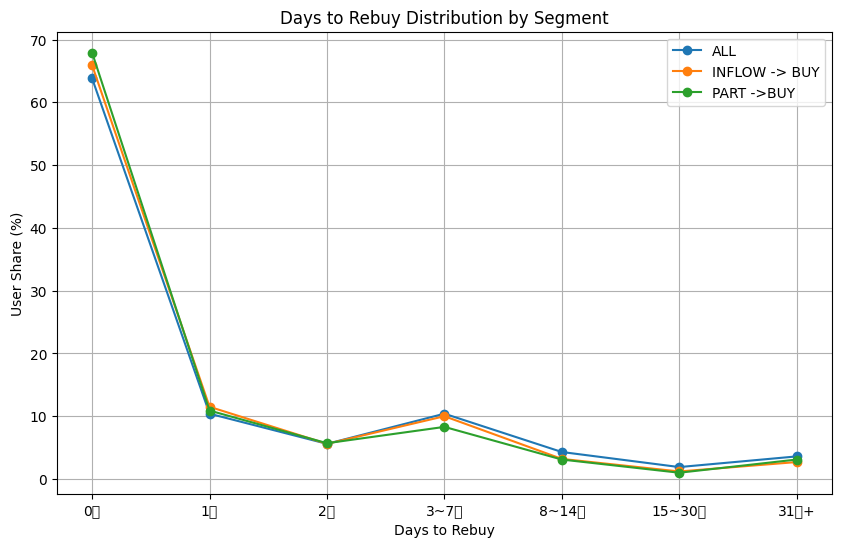

In [173]:
import matplotlib.pyplot as plt

# dist 구조 확인
print(dist.head())

# index = 구간 (0일, 1일, 2일, 3~7일 ...)

plt.figure(figsize=(10,6))

for col in dist.columns:
    plt.plot(dist.index, dist[col], marker='o', label=col)

plt.title("Days to Rebuy Distribution by Segment")
plt.xlabel("Days to Rebuy")
plt.ylabel("User Share (%)")
plt.legend()
plt.grid(True)

plt.show()

In [182]:
# 3~5 / 6~7로 추가로 나누기
def make_dist_split_3_7(rebuy_df: pd.DataFrame) -> pd.Series:
    x = rebuy_df["days_to_rebuy"].dropna().astype(int)
    bins = [-1, 0, 1, 2, 5, 7, 14, 30, np.inf]
    labels = ["0일", "1일", "2일", "3~5일", "6~7일", "8~14일", "15~30일", "31일+"]

    cat = pd.cut(x, bins=bins, labels=labels)
    share = cat.value_counts(normalize=True).reindex(labels).fillna(0) * 100
    return share

# rebuy_all / rebuy_inflow / rebuy_part 를 사용해서 dist 다시 만들기
dist2 = pd.DataFrame({
    "ALL": make_dist_split_3_7(rebuy_all),
    "INFLOW -> BUY": make_dist_split_3_7(rebuy_inflow),
    "PART -> BUY": make_dist_split_3_7(rebuy_part),
})

print(dist2)


                     ALL  INFLOW -> BUY  PART -> BUY
days_to_rebuy                                       
0일             63.812651      65.850968    67.875648
1일             10.433059      11.503360    10.880829
2일              5.644012       5.646374     5.699482
3~5일            7.837185       7.642162     5.699482
6~7일            2.540115       2.316718     2.590674
8~14일           4.305805       3.179220     3.108808
15~30일          1.852426       1.153345     1.036269
31일+            3.574748       2.707853     3.108808


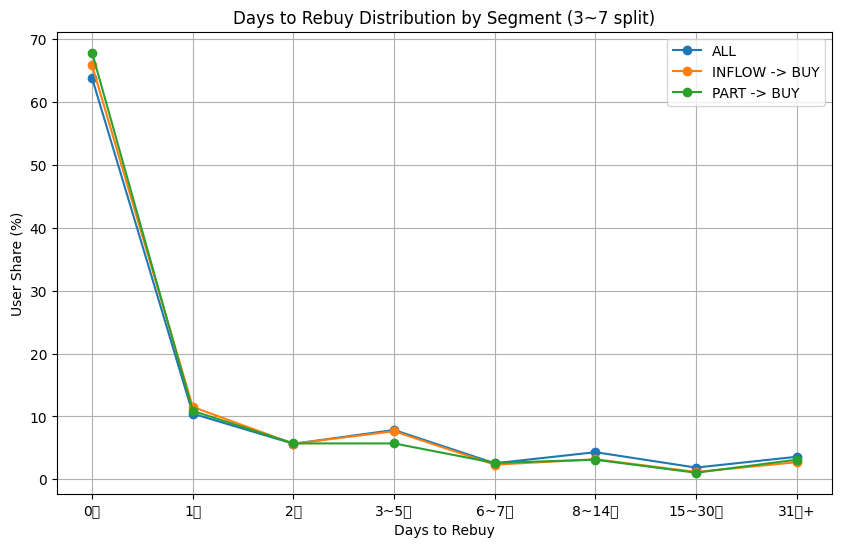

In [181]:
# 그래프
plt.figure(figsize=(10,6))
for col in dist2.columns:
    plt.plot(dist2.index, dist2[col], marker='o', label=col)

plt.title("Days to Rebuy Distribution by Segment (3~7 split)")
plt.xlabel("Days to Rebuy")
plt.ylabel("User Share (%)")
plt.legend()
plt.grid(True)

# CRM 근거선
labels = list(dist2.index)
idx_1d = labels.index("1일")
idx_3_5 = labels.index("3~5일")

plt.show()

/Users/10moo/260128_proj/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


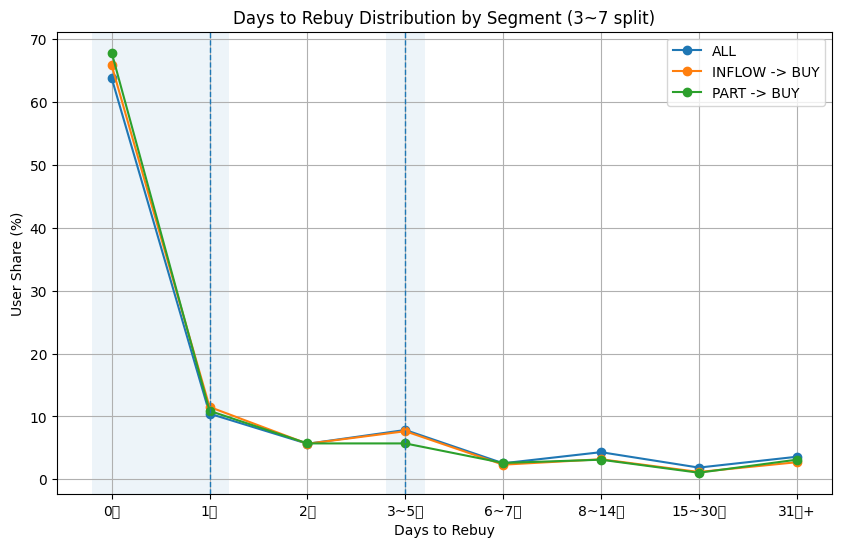

In [183]:
# 음영 추가

plt.figure(figsize=(10,6))
for col in dist2.columns:
    plt.plot(dist2.index, dist2[col], marker='o', label=col)

plt.title("Days to Rebuy Distribution by Segment (3~7 split)")
plt.xlabel("Days to Rebuy")
plt.ylabel("User Share (%)")
plt.legend()
plt.grid(True)

labels = list(dist2.index)
idx_1d = labels.index("1일")
idx_3_5 = labels.index("3~5일")

plt.axvline(idx_1d, linestyle="--", linewidth=1)
plt.axvline(idx_3_5, linestyle="--", linewidth=1)

# 0~1일 / 3~5일 구간 음영
plt.axvspan(-0.2, idx_1d + 0.2, alpha=0.08)
plt.axvspan(idx_3_5 - 0.2, idx_3_5 + 0.2, alpha=0.08)

plt.show()

- 세그먼트? 분석

In [184]:
# 유저별 구매 Feature 만들기

pay_sorted = pay.sort_values(["user_id", "created_at"]).copy()
pay_sorted["order"] = pay_sorted.groupby("user_id").cumcount() + 1

# 유저별 tx
user_tx = pay_sorted.groupby("user_id").size().rename("tx").reset_index()

# 첫 구매 / 두번째 구매 시각
first_buy  = pay_sorted.loc[pay_sorted["order"] == 1, ["user_id", "created_at"]].rename(columns={"created_at":"first_buy_at"})
second_buy = pay_sorted.loc[pay_sorted["order"] == 2, ["user_id", "created_at"]].rename(columns={"created_at":"second_buy_at"})

# 유저별 구매 active day 수 (며칠 동안 결제했는지)
pay_sorted["buy_date"] = pay_sorted["created_at"].dt.date
active_days = pay_sorted.groupby("user_id")["buy_date"].nunique().rename("buy_active_days").reset_index()

# 유저별 구매 간격(첫~마지막 구매 기간)
minmax = pay_sorted.groupby("user_id")["created_at"].agg(["min","max"]).reset_index()
minmax["buy_span_days"] = (minmax["max"] - minmax["min"]).dt.days
minmax = minmax.drop(columns=["min","max"])

# merge
feat = user_tx.merge(first_buy, on="user_id", how="left") \
              .merge(second_buy, on="user_id", how="left") \
              .merge(active_days, on="user_id", how="left") \
              .merge(minmax, on="user_id", how="left")

# 재구매까지 걸린 시간 (2회 이상 구매자만)
feat["days_to_rebuy"] = (feat["second_buy_at"] - feat["first_buy_at"]).dt.days

# 구매 속도/강도 보조 feature
feat["tx_per_active_day"] = feat["tx"] / feat["buy_active_days"].replace(0, np.nan)
feat["is_rebuyer"] = feat["tx"] >= 2

In [186]:
# 세그먼트 정의 (타이밍 + 반복 패턴)
# 단순 헤비/라이트 X
### 재구매 타이밍 + 구매 밀도

def assign_segment(row):
    tx = row["tx"]
    d2 = row["days_to_rebuy"]
    span = row["buy_span_days"]
    dens = row["tx_per_active_day"]

    # 1회 구매자는 전환 기회가 가장 큼
    if tx == 1:
        return "one buy (1회구매)"

    # 2회 이상 구매자: 재구매 타이밍이 곧 CRM 타이밍
    # 0~1일 내 재구매 = “즉시 반복형”
    if pd.notna(d2) and d2 <= 1:
        # 그 중에서도 구매가 짧은 기간에 몰리면 “SPRINTER”
        if pd.notna(span) and span <= 3 and pd.notna(dens) and dens >= 1.2:
            return "vip (초단기 몰아구매)"
        return "quick rebuy (즉시 재구매)"

    # 2~7일 내 재구매 = “따라오는 타입”
    if pd.notna(d2) and 2 <= d2 <= 7:
        return "normal rebuy (1주 내 재구매)"

    # 8일+ 재구매 = “롱테일”
    if pd.notna(d2) and d2 >= 8:
        # 롱테일인데 tx가 높으면 “SLOW LOYAL”
        if tx >= 3:
            return "slow royalty (늦지만 꾸준)"
        return "slow rebuy (늦은 재구매)"

    # 예외(데이터 결측 등)
    return "unknown"

feat["segment"] = feat.apply(assign_segment, axis=1)

In [190]:
# 집단별 요약 테이블

def cohort_summary(feat_df, cohort_name, user_set=None):
    if user_set is not None:
        sub = feat_df[feat_df["user_id"].isin(user_set)].copy()
    else:
        sub = feat_df.copy()

    # 세그먼트 분포
    seg_cnt = sub["segment"].value_counts().rename("users").reset_index().rename(columns={"index":"segment"})
    seg_cnt["cohort"] = cohort_name
    seg_cnt["share"] = seg_cnt["users"] / seg_cnt["users"].sum()

    # 재구매 타이밍 요약 (2회 이상만)
    reb = sub[sub["tx"] >= 2].copy()
    if len(reb) > 0:
        timing = {
            "rebuy_users(2+)": len(reb),
            "median_days": float(reb["days_to_rebuy"].median()),
            "p75_days": float(reb["days_to_rebuy"].quantile(0.75)),
            "p90_days": float(reb["days_to_rebuy"].quantile(0.90)),
            "share_0d": float((reb["days_to_rebuy"] == 0).mean()),
            "share_le_1d": float((reb["days_to_rebuy"] <= 1).mean()),
            "share_le_2d": float((reb["days_to_rebuy"] <= 2).mean()),
            "share_le_3d": float((reb["days_to_rebuy"] <= 3).mean()),
            "share_le_7d": float((reb["days_to_rebuy"] <= 7).mean()),
        }
    else:
        timing = {
            "rebuy_users(2+)": 0,
            "median_days": np.nan,
            "p75_days": np.nan,
            "p90_days": np.nan,
            "share_0d": np.nan,
            "share_le_1d": np.nan,
            "share_le_2d": np.nan,
            "share_le_3d": np.nan,
            "share_le_7d": np.nan,
        }

    timing_df = pd.DataFrame([{"cohort": cohort_name, **timing}])
    return seg_cnt, timing_df

seg_all, timing_all       = cohort_summary(feat, "ALL", None)
seg_inflow, timing_inflow = cohort_summary(feat, "INFLOW -> BUY", inflow_buyers)
seg_part, timing_part     = cohort_summary(feat, "PART -> BUY", part_buyers)

seg_table = pd.concat([seg_all, seg_inflow, seg_part], ignore_index=True)
timing_table = pd.concat([timing_all, timing_inflow, timing_part], ignore_index=True)

print("Segment Share Table")
print(seg_table.sort_values(["cohort","share"], ascending=[True, False]))

print("\nRebuy Timing Table")
print(timing_table)


Segment Share Table
                    segment  users         cohort     share
0            one buy (1회구매)  43050            ALL  0.727307
1            vip (초단기 몰아구매)   7764            ALL  0.131169
2      quick rebuy (즉시 재구매)   4220            ALL  0.071295
3   normal rebuy (1주 내 재구매)   2586            ALL  0.043689
4       slow rebuy (늦은 재구매)   1092            ALL  0.018449
5     slow royalty (늦지만 꾸준)    479            ALL  0.008092
6            one buy (1회구매)  24398  INFLOW -> BUY  0.709884
7            vip (초단기 몰아구매)   4921  INFLOW -> BUY  0.143181
8      quick rebuy (즉시 재구매)   2792  INFLOW -> BUY  0.081236
9   normal rebuy (1주 내 재구매)   1556  INFLOW -> BUY  0.045273
10      slow rebuy (늦은 재구매)    499  INFLOW -> BUY  0.014519
11    slow royalty (늦지만 꾸준)    203  INFLOW -> BUY  0.005906
12           one buy (1회구매)    480    PART -> BUY  0.713224
13           vip (초단기 몰아구매)     90    PART -> BUY  0.133730
14     quick rebuy (즉시 재구매)     62    PART -> BUY  0.092125
15  normal rebuy (1주

/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_2773/1415034783.py:14: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_2773/1415034783.py:14: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_2773/1415034783.py:14: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_2773/1415034783.py:14: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_2773/1415034783.py:14: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_277

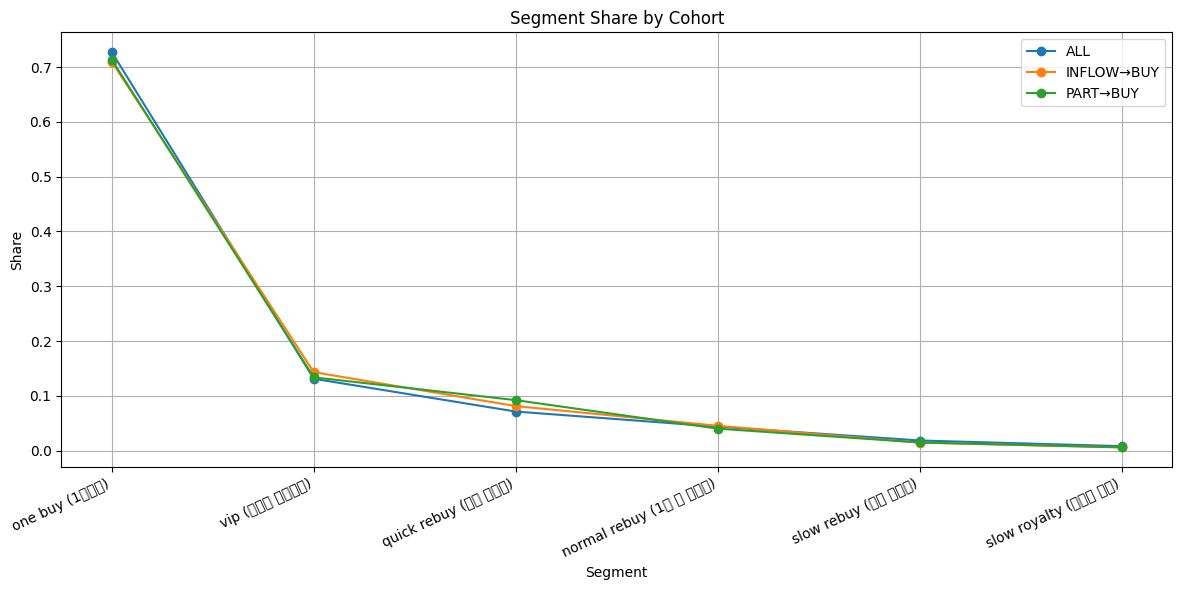

In [188]:
# 세그먼트 비중 집단별 막대

pivot_share = seg_table.pivot_table(index="segment", columns="cohort", values="share", fill_value=0).sort_values("ALL", ascending=False)

plt.figure(figsize=(12,6))
for col in pivot_share.columns:
    plt.plot(pivot_share.index, pivot_share[col].values, marker="o", label=col)
plt.title("Segment Share by Cohort")
plt.xlabel("Segment")
plt.ylabel("Share")
plt.xticks(rotation=25, ha="right")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

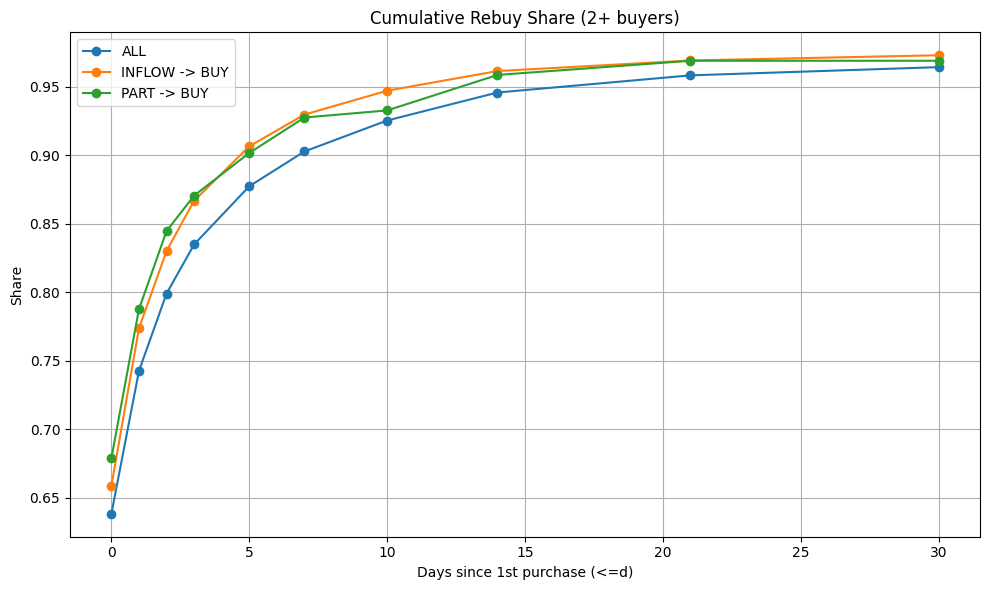

In [191]:
# 재구매 타이밍 누적(<=d) (집단별)
# 누적 비율 (0~14일, 21일, 30일 기준)
days_list = [0,1,2,3,5,7,10,14,21,30]

def cum_rebuy_curve(feat_df, cohort_name, user_set=None):
    if user_set is not None:
        sub = feat_df[feat_df["user_id"].isin(user_set)].copy()
    else:
        sub = feat_df.copy()

    reb = sub[sub["tx"] >= 2].copy()
    y = []
    for d in days_list:
        y.append((reb["days_to_rebuy"] <= d).mean() if len(reb) > 0 else np.nan)
    return pd.Series(y, index=days_list, name=cohort_name)

curve_all = cum_rebuy_curve(feat, "ALL", None)
curve_inflow = cum_rebuy_curve(feat, "INFLOW -> BUY", inflow_buyers)
curve_part = cum_rebuy_curve(feat, "PART -> BUY", part_buyers)

curves = pd.concat([curve_all, curve_inflow, curve_part], axis=1)

plt.figure(figsize=(10,6))
for col in curves.columns:
    plt.plot(curves.index, curves[col], marker="o", label=col)
plt.title("Cumulative Rebuy Share (2+ buyers)")
plt.xlabel("Days since 1st purchase (<=d)")
plt.ylabel("Share")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()